In [1]:
from collections import defaultdict
import evaluate
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os

/home/mkersten/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
# Labels for charts, tables
models = {'electra-base-discriminator': 'ELECTRA', 'google': 'ELECTRA', 'google/electra-base-discriminator': 'ELECTRA', 'roberta-base': 'RoBERTa', 'bert-base-uncased': 'BERT', 'distilbert-base-uncased': 'DistilBERT', 'elmo':'ELMo'}
metrics_short = {'accuracy': 'A', 'precision': 'P', 'recall': 'R', 'f1': 'F1'}

### Visualization on **text length** distribution

##### - Visualize word count distribution after preprocessing 

In [2]:
# Load baseline test data
path_to_baseline = "pipeline/text-based/data/test.csv"
df_baseline = pd.read_csv(path_to_baseline, usecols=['ID','text', 'label'],index_col='ID', nrows=359)

df_baseline['text'] = df_baseline['text'].fillna('') # Replace np.NaN with empty strings
df_baseline["label"] = df_baseline["label"].map({"FAKE": 0, "REAL": 1})

# 1. Add column with number of words
df_baseline['word_count'] = df_baseline['text'].str.split().apply(len)
df_baseline.drop('text', axis=1, inplace=True)

display(df_baseline.head(2))
print(df_baseline.shape)

,label,word_count
ID,,
1197,1,7
9795,0,0


(359, 2)


In [3]:
# Load test arg-bassd data
path_to_arg = "pipeline/argumentation-based/argumentation structure/dolly/test.csv"
df_arg = pd.read_csv(path_to_arg, index_col='ID', usecols=['ID', 'text', 'label'], nrows=359).dropna()
df_arg["label"] = df_arg["label"].map({"FAKE": 0, "REAL": 1})

# 1. Add column with number of words
df_arg['word_count'] = df_arg['text'].str.split().apply(len)
df_arg.drop('text', axis=1, inplace=True)

display(df_arg.head(2))
print(df_arg.shape)

,label,word_count
ID,,
1197,1,17
9795,0,5


(359, 2)


[]

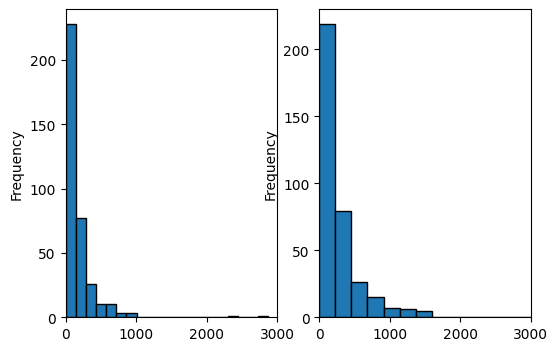

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))

df_baseline['word_count'].plot(kind='hist', bins=20, edgecolor='black', ax=ax[0])
df_arg['word_count'].plot(kind='hist', bins=20, ax=ax[1], edgecolor='black')
ax[0].set_xlim(0, 3000)  
ax[1].set_xlim(0, 3000) 
plt.plot()


##### - Visualize F1 score depending on word count

TODO:
1. Kolom met lengte nieuws artikel toevoegen op test set.
2. Logische categorieën bedenken voor woorden
3. Modellen op baseline en argument component pipeline model runnen op unlabeled test data.
4. Predictions FAKE/REAL opslaan per artikel
4. 'Handmatig' de F1 berekenen per logisch bedachte categorie lengte woorden stap 2.
5. Lineplot of barplot maken met Y F1 accuracy en X lengte woorden.

In [5]:
def get_labels(path_to_labels):
    # Read test data with labels
    df_labels = pd.read_csv(f"{path_to_labels}.csv", usecols=['ID', 'text', 'label'], index_col='ID').dropna()

    # Convert string to int label
    df_labels["label"] = df_labels["label"].map({"FAKE": 0, "REAL": 1})

    # Count the number of words
    df_labels['word_count'] = df_labels['text'].str.split().apply(len)

    # Add bins depending on the words
    df_labels['bin_id'] = pd.cut(df_labels['word_count'], bins=[0, 100, 300, 10000], labels=["Short", "Medium", "Long"],right=True)
    return df_labels

In [6]:
metric = evaluate.combine(["f1"])

def process_predictions(df_labels, path_to_best_model_predictions):

    # Load predictions for best model
    df_predictions = pd.read_csv(f"{path_to_best_model_predictions}", usecols=['ID', 'prediction'], index_col='ID')

    # Combine predictions and correct labels
    df = pd.concat([df_labels, df_predictions], axis=1)

    # Group df by bin
    grouped_df = df.groupby('bin_id')

    # Calculate F1 score per bin
    f1_per_batch = []    
    for idx, data in grouped_df:
        labels = data['label'].values
        preds = data['prediction'].values
        result = metric.compute(labels, preds)
        print(idx, len(data), result['f1'])
        f1_per_batch.append(result['f1'])
    
    return f1_per_batch

In [7]:
def plot_lines(performance, ax):
    fig_labels = [i for i in performance]
    y_values = [performance[i] for i in performance]
    x_values = np.arange(1, len(y_values[0]) + 1)

    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label=fig_labels[i])
    
    return ax

In [8]:
# Baseline
baseline_path_to_labels = "pipeline/text-based/data/test"
base_path_best_model_preds = "pipeline/text-based/results/roberta-base_predictions.csv"
performance_baseline = process_predictions(get_labels(baseline_path_to_labels), base_path_best_model_preds)

Short 251 0.721518987341772
Medium 121 0.8
Long 69 0.8791208791208791


In [9]:
# ARG
best_models_margot = {
    'claim': 'pipeline/argumentation-based/results/margot/claim/google_predictions.csv',
    'evidence': 'pipeline/argumentation-based/results/margot/evidence/distilbert-base-uncased_predictions.csv',
    'structure': 'pipeline/argumentation-based/results/margot/structure/google_predictions.csv'
}

best_models_dolly = {
    'claim': 'pipeline/argumentation-based/results/dolly/claim/google_predictions.csv',
    'evidence': 'pipeline/argumentation-based/results/dolly/evidence/distilbert-base-uncased_predictions.csv',
    'structure': 'pipeline/argumentation-based/results/dolly/structure/roberta-base_predictions.csv'
}

In [10]:
def per_component(path_to_labels, best_models):
    performance = {}
    df_labels = get_labels(path_to_labels)

    for comp in ['structure', 'claim', 'evidence']:
        f1_scores = process_predictions(df_labels, best_models[comp])
        performance[comp] = f1_scores
    return performance

Short 130 0.731958762886598
Medium 58 0.9310344827586207
Long 171 0.9608938547486033
Short 130 0.7326732673267327
Medium 58 0.7088607594936709
Long 171 0.7867298578199051
Short 130 0.6341463414634146
Medium 58 0.9152542372881356
Long 171 0.9617486338797815
Short 242 0.7147335423197492
Medium 58 0.8181818181818182
Long 143 0.8296296296296296
Short 242 0.702127659574468
Medium 58 0.7619047619047619
Long 143 0.7972027972027972
Short 242 0.7077922077922079
Medium 58 0.7391304347826089
Long 143 0.8270676691729324


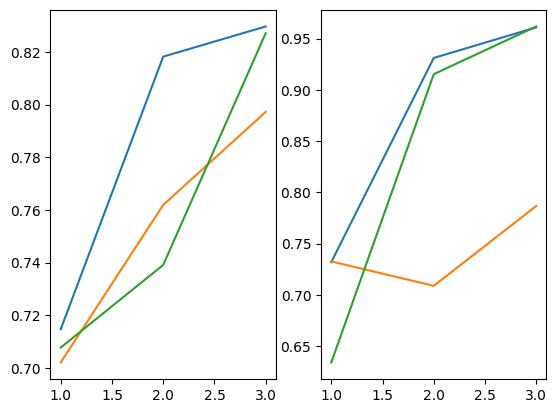

In [11]:
# Add MARGOT 
path_to_labels = "pipeline/argumentation-based/argumentation structure"

performance_margot = per_component(f"{path_to_labels}/margot/test", best_models_margot)
performance_dolly = per_component(f"{path_to_labels}/dolly/test", best_models_dolly)

with open('perf_margot.json', 'w') as json_file:
    json.dump(performance_margot, json_file, indent=4)

with open('perf_dolly.json', 'w') as json_file:
    json.dump(performance_dolly, json_file, indent=4)

fig, ax = plt.subplots(1, 2)

ax[0] = plot_lines(performance_dolly, ax[0])
ax[1] = plot_lines(performance_margot, ax[1])



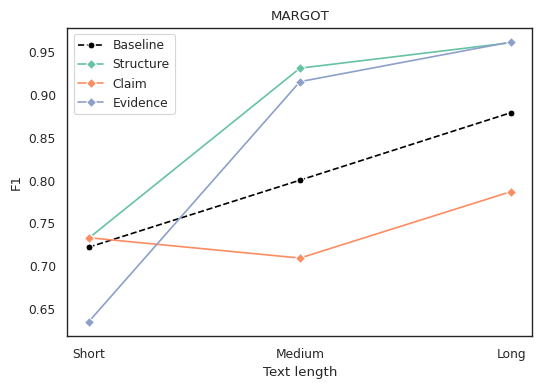

In [55]:
# BASELINE + MARGOT 
sns.set_style("white")
sns.set_context('paper')

plt.figure(figsize=(6, 4))
ax = sns.lineplot(performance_baseline, marker='o',linestyle='--', color="black", markersize=5, label='Baseline')
ax.set_xticks(range(len(performance_baseline)))
ax.set_xticklabels(['Short', 'Medium', 'Long'])
ax.set(xlabel='Text length', ylabel='F1')
ax.set(title="MARGOT")

palette = sns.color_palette("Set2")

for i, (label, data) in enumerate(performance_margot.items()):
    sns.lineplot(x=[0, 1, 2], y=data, marker='D', label=label.capitalize(), markersize=5, ax=ax, color=palette[i])

# plt.show()

plt.savefig("margot_text_length.png")

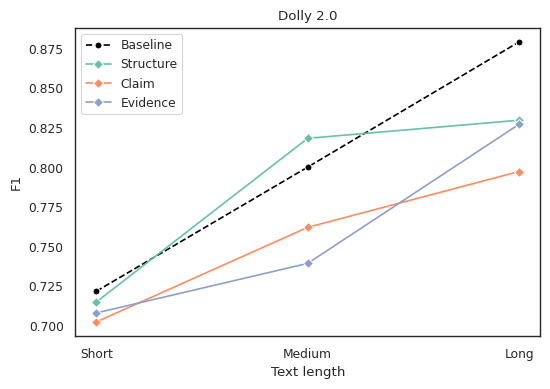

In [53]:
# Baseline + Dolly
sns.set_style("white")
sns.set_context('paper')

plt.figure(figsize=(6, 4))
ax = sns.lineplot(performance_baseline, marker='o',linestyle='--', color="black", markersize=5, label='Baseline')
ax.set_xticks(range(len(performance_baseline)))
ax.set(title="Dolly 2.0")
ax.set_xticklabels(['Short', 'Medium', 'Long'])
ax.set(xlabel='Text length', ylabel='F1')

palette = sns.color_palette("Set2")

for i, (label, data) in enumerate(performance_dolly.items()):
    sns.lineplot(x=[0, 1, 2], y=data, marker='D', label=label.capitalize(), markersize=5, ax=ax, color=palette[i])

# plt.show()
plt.savefig("dolly_text_length.png")

### Visualization on **validation** set

In [ ]:
MODE = 'argumentation-based'
if MODE == 'argumentation-based':
    TOOL = 'margot'
    ELEMENT = 'structure'

    input_path = f"models/{MODE}/{TOOL}/{ELEMENT}/training/"
    output_path = f'pipeline/{MODE}/results/figures/{TOOL}_{ELEMENT}.png'
else:
    input_path = f"models/{MODE}/training/"
    output_path = f'pipeline/{MODE}/results/figures/baseline.png'

In [ ]:
# Plot results baseline

res = defaultdict(dict)
x_values, y_values, hue_values = [], [], []

for root, dirs, files in os.walk(input_path):
    mets = []
    for file in files:

        # Look for trainer_state.json files for all models except for ELMo 
        if file == 'trainer_state.json':
            # PREPARE FOR TABLE
            metrics = {}

            model_name = os.path.basename(os.path.dirname(os.path.dirname(root)))
            dataset = os.path.basename(os.path.dirname(root))
            trainer_state = os.path.join(root, file)

            with open(trainer_state) as f:
                data = json.load(f)

            f1 = data["log_history"][1]["eval_f1"]
            accuracy = data["log_history"][1]["eval_accuracy"]
            recall = data["log_history"][1]["eval_recall"]
            precision = data["log_history"][1]["eval_precision"]

            metrics['F1'] = "{:.2f}".format(f1)
            metrics['Accuracy'] = "{:.2f}".format(accuracy)
            metrics['Recall'] = "{:.2f}".format(recall)
            metrics['Precision'] = "{:.2f}".format(precision)

            res[models[model_name]][datasets[dataset]] = metrics

            # PREPARE FOR CHART 
            x_values.append(models[model_name])
            hue_values.append(datasets[dataset])
            y_values.append(float("{:.2f}".format(f1)))

        # Prepare doing the same for ELMo
        if 'elmo' in os.path.dirname(root):
            if file.endswith('.json'):
                mets.append(file)    
    
    # All ELMo from here
    mets_sorted = sorted(mets, key=lambda x: int(x.split(".")[0][-1]), reverse=True) # Only keep best EPOCH

    if mets_sorted:
        metrics = {}
        model_name = os.path.basename(os.path.dirname(root))
        dataset = os.path.basename(root)
        best_metric = mets_sorted[0]
        best_mets_file = os.path.join(root, best_metric)

        with open(best_mets_file) as f:
            data = json.load(f)
        
        f1 = data["best_validation_f1"]
        accuracy = data["best_validation_accuracy"]
        precision = data["best_validation_precision"]
        recall = data["best_validation_recall"]

        metrics['Accuracy'] = "{:.2f}".format(accuracy)
        metrics['Precision'] = "{:.2f}".format(precision)
        metrics['Recall'] = "{:.2f}".format(recall)
        metrics['F1'] = "{:.2f}".format(f1)

        
        res[models[model_name]][datasets[dataset]] = metrics

        # PREPARE FOR CHART
        x_values.append(models[model_name])
        hue_values.append(datasets[dataset])   
        y_values.append(float("{:.2f}".format(f1)))

In [ ]:
res

In [ ]:
# F1 table only
index = res.keys()
values = []
cols = []

for model_name, d in res.items():
    tmp_cols = []

    for dataset, scores in d.items():
        for metric, score in scores.items():
            if metric == 'F1':
                values.append(score)
                tmp_cols.append((dataset, metric))

cols.append(tmp_cols)

# Flatten columns
cols = sum(cols, [])

multi_index = pd.MultiIndex.from_tuples(cols)

# Reshape the values
reshaped_values = np.array(values).reshape(-1, len(index))  

df = pd.DataFrame(reshaped_values, index=multi_index, columns=index)
df = df.T

df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])

print(df.to_latex())

In [ ]:
# Full table (A, P, R, F1)
# Create table with 2 level index (dataset, metric), columns are the models, values are the scores
reformed = []
for k, v in res.items():
    x = {(outerKey, innerKey): values for outerKey, innerDict in v.items() for innerKey, values in innerDict.items()}
    y = pd.DataFrame(x, index=[k])
    reformed.append(y)

df = pd.concat(reformed)
df = df.reindex(index=['BERT', 'RoBERTa', 'DistilBERT', 'ELECTRA', 'ELMo'])
df


In [ ]:
# For thesis
print(df.to_latex())

In [ ]:
sns.set_style("whitegrid")
sns.set_context('paper')

plt.figure(figsize=(6, 4))

ax = sns.barplot(x=x_values, y=y_values, hue=hue_values, palette="deep")
sns.move_legend(ax, "lower center", 
    bbox_to_anchor=(.5, 1), ncol=4, title=None, frameon=False)

ax.set_yticks(list(np.arange(0,1.1,0.1)))
plt.ylabel('F1')

plt.savefig(f"{output_path}.png")

### Visualisation on **test** set

#### Baseline pipeline

In [23]:
# Concat inference results
path_to_baseline_performance = "/home/mkersten/fake_news/pipeline/text-based/results/json/performance_test.json"

with open(path_to_baseline_performance) as json_file:
    performance = json.load(json_file)
print(performance)

{'google': {'accuracy': 0.7301587301587301, 'precision': 0.6819923371647509, 'recall': 0.8317757009345794, 'f1': 0.7494736842105263}, 'roberta-base': {'accuracy': 0.7414965986394558, 'precision': 0.6865671641791045, 'recall': 0.8598130841121495, 'f1': 0.7634854771784233}, 'bert-base-uncased': {'accuracy': 0.7505668934240363, 'precision': 0.7921348314606742, 'recall': 0.6588785046728972, 'f1': 0.7193877551020409}, 'distilbert-base-uncased': {'accuracy': 0.7346938775510204, 'precision': 0.702928870292887, 'recall': 0.7850467289719626, 'f1': 0.7417218543046358}}


In [42]:
idx = [models[i] for i in performance]
values = [["{:.2f}".format(performance[i][j]) for j in performance[i]] for i in performance]

df = pd.DataFrame(values, index=idx, columns=['Accuracy', 'Precision', 'Recall', 'F1'])
print(df.to_latex())

\begin{tabular}{lllll}
\toprule
 & Accuracy & Precision & Recall & F1 \\
\midrule
ELECTRA & 0.73 & 0.68 & 0.83 & 0.75 \\
RoBERTa & 0.74 & 0.69 & 0.86 & 0.76 \\
BERT & 0.75 & 0.79 & 0.66 & 0.72 \\
DistilBERT & 0.73 & 0.70 & 0.79 & 0.74 \\
\bottomrule
\end{tabular}



#### Argumentation-based pipeline

In [106]:
# Concat inference results
path_to_dolly = "pipeline/argumentation-based/results/dolly"

performance_dolly = {}
for component_name in os.listdir(path_to_dolly):
    path_to_json = f"{path_to_dolly}/{component_name}/json"
    for f in os.listdir(path_to_json):
        path = os.path.join(path_to_json, f)
        with open(path) as f:
            json_results = json.load(f)
            performance_dolly[component_name] = json_results
print(performance_dolly)

{'evidence': {'google': {'accuracy': 0.6839729119638827, 'precision': 0.6193548387096774, 'recall': 0.897196261682243, 'f1': 0.7328244274809161}, 'roberta-base': {'accuracy': 0.6884875846501128, 'precision': 0.6301369863013698, 'recall': 0.8598130841121495, 'f1': 0.7272727272727273}, 'bert-base-uncased': {'accuracy': 0.708803611738149, 'precision': 0.6679841897233202, 'recall': 0.7897196261682243, 'f1': 0.7237687366167025}, 'distilbert-base-uncased': {'accuracy': 0.7178329571106095, 'precision': 0.663003663003663, 'recall': 0.8457943925233645, 'f1': 0.7433264887063654}}, 'claim': {'google': {'accuracy': 0.7223476297968398, 'precision': 0.6798418972332015, 'recall': 0.8037383177570093, 'f1': 0.7366167023554603}, 'roberta-base': {'accuracy': 0.7065462753950339, 'precision': 0.7142857142857143, 'recall': 0.6542056074766355, 'f1': 0.6829268292682927}, 'bert-base-uncased': {'accuracy': 0.6975169300225733, 'precision': 0.6538461538461539, 'recall': 0.794392523364486, 'f1': 0.7172995780590717

In [108]:
path_to_margot = "pipeline/argumentation-based/results/margot"

performance_margot = {}
for component_name in os.listdir(path_to_dolly):
    path_to_json = f"{path_to_margot}/{component_name}/json"
    for f in os.listdir(path_to_json):
        path = os.path.join(path_to_json, f)
        with open(path) as f:
            json_results = json.load(f)
            performance_margot[component_name] = json_results
print(performance_margot)

{'evidence': {'google': {'accuracy': 0.8022284122562674, 'precision': 0.7510204081632653, 'recall': 0.9484536082474226, 'f1': 0.8382687927107062}, 'roberta-base': {'accuracy': 0.8245125348189415, 'precision': 0.896969696969697, 'recall': 0.7628865979381443, 'f1': 0.8245125348189414}, 'bert-base-uncased': {'accuracy': 0.8328690807799443, 'precision': 0.8850574712643678, 'recall': 0.7938144329896907, 'f1': 0.8369565217391305}, 'distilbert-base-uncased': {'accuracy': 0.841225626740947, 'precision': 0.9005847953216374, 'recall': 0.7938144329896907, 'f1': 0.843835616438356}}, 'claim': {'google': {'accuracy': 0.6601671309192201, 'precision': 0.6208053691275168, 'recall': 0.9536082474226805, 'f1': 0.7520325203252032}, 'roberta-base': {'accuracy': 0.6434540389972145, 'precision': 0.6170212765957447, 'recall': 0.8969072164948454, 'f1': 0.73109243697479}, 'bert-base-uncased': {'accuracy': 0.6573816155988857, 'precision': 0.6263345195729537, 'recall': 0.9072164948453608, 'f1': 0.7410526315789474}

In [109]:
# Dolly: Full table (A, P, R, F1)
cols, values = [], []
for i in performance_dolly:
    tmp_col, idx = [], []
    for k, v in performance_dolly[i].items():

        idx.append(models[k])

        metric = [(i,metrics[j]) for j in performance_dolly[i][k]]
        value = [(performance_dolly[i][k][j]) for j in performance_dolly[i][k]]
        for a, b in performance_dolly[i][k].items():
            value = "{:.2f}".format(b)
            values.append(value)

    cols.append(metric)

cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols, names=['component', 'metric'])
reshaped_values = np.array(values).reshape(-1, 12)  
df_dolly = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)
display(df_dolly)
print(df_dolly.to_latex())

component  evidence                   claim                   structure        \
metric            A     P     R    F1     A     P     R    F1         A     P   
ELECTRA        0.68  0.62  0.90  0.73  0.69  0.63  0.86  0.73      0.71  0.67   
RoBERTa        0.72  0.66  0.85  0.74  0.72  0.68  0.80  0.74      0.71  0.71   
BERT           0.70  0.65  0.79  0.72  0.69  0.63  0.84  0.72      0.72  0.71   
DistilBERT     0.72  0.66  0.88  0.76  0.71  0.64  0.91  0.75      0.71  0.68   

component               
metric         R    F1  
ELECTRA     0.79  0.72  
RoBERTa     0.65  0.68  
BERT        0.69  0.70  
DistilBERT  0.77  0.72

\begin{tabular}{lllllllllllll}
\toprule
component & \multicolumn{4}{r}{evidence} & \multicolumn{4}{r}{claim} & \multicolumn{4}{r}{structure} \\
metric & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 \\
\midrule
ELECTRA & 0.68 & 0.62 & 0.90 & 0.73 & 0.69 & 0.63 & 0.86 & 0.73 & 0.71 & 0.67 & 0.79 & 0.72 \\
RoBERTa & 0.72 & 0.66 & 0.85 & 0.74 & 0.72 & 0.68 & 0.80 & 0.74 & 0.71 & 0.71 & 0.65 & 0.68 \\
BERT & 0.70 & 0.65 & 0.79 & 0.72 & 0.69 & 0.63 & 0.84 & 0.72 & 0.72 & 0.71 & 0.69 & 0.70 \\
DistilBERT & 0.72 & 0.66 & 0.88 & 0.76 & 0.71 & 0.64 & 0.91 & 0.75 & 0.71 & 0.68 & 0.77 & 0.72 \\
\bottomrule
\end{tabular}



In [111]:
# MARGOT: Full table (A, P, R, F1)
cols, values = [], []
for i in performance_margot:
    tmp_col, idx = [], []
    for k, v in performance_margot[i].items():

        idx.append(models[k])

        metric = [(i,metrics[j]) for j in performance_margot[i][k]]
        value = [(performance_margot[i][k][j]) for j in performance_margot[i][k]]
        for a, b in performance_margot[i][k].items():
            value = "{:.2f}".format(b)
            values.append(value)

    cols.append(metric)

cols = sum(cols, [])
multi_columns = pd.MultiIndex.from_tuples(cols, names=['component', 'metric'])
reshaped_values = np.array(values).reshape(-1, 12)  
df_margot = pd.DataFrame(reshaped_values, index=idx, columns=multi_columns)
display(df_margot)
print(df_margot.to_latex())

component  evidence                   claim                   structure        \
metric            A     P     R    F1     A     P     R    F1         A     P   
ELECTRA        0.80  0.75  0.95  0.84  0.82  0.90  0.76  0.82      0.83  0.89   
RoBERTa        0.84  0.90  0.79  0.84  0.66  0.62  0.95  0.75      0.64  0.62   
BERT           0.66  0.63  0.91  0.74  0.66  0.63  0.91  0.74      0.82  0.78   
DistilBERT     0.84  0.92  0.77  0.84  0.83  0.88  0.80  0.84      0.82  0.85   

component               
metric         R    F1  
ELECTRA     0.79  0.84  
RoBERTa     0.90  0.73  
BERT        0.95  0.85  
DistilBERT  0.82  0.83

\begin{tabular}{lllllllllllll}
\toprule
component & \multicolumn{4}{r}{evidence} & \multicolumn{4}{r}{claim} & \multicolumn{4}{r}{structure} \\
metric & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 \\
\midrule
ELECTRA & 0.80 & 0.75 & 0.95 & 0.84 & 0.82 & 0.90 & 0.76 & 0.82 & 0.83 & 0.89 & 0.79 & 0.84 \\
RoBERTa & 0.84 & 0.90 & 0.79 & 0.84 & 0.66 & 0.62 & 0.95 & 0.75 & 0.64 & 0.62 & 0.90 & 0.73 \\
BERT & 0.66 & 0.63 & 0.91 & 0.74 & 0.66 & 0.63 & 0.91 & 0.74 & 0.82 & 0.78 & 0.95 & 0.85 \\
DistilBERT & 0.84 & 0.92 & 0.77 & 0.84 & 0.83 & 0.88 & 0.80 & 0.84 & 0.82 & 0.85 & 0.82 & 0.83 \\
\bottomrule
\end{tabular}



In [112]:
combined = pd.concat([df_dolly, df_margot], axis=1)
display(combined.head(5))
print(combined.to_latex())

component  evidence                   claim                   structure        \
metric            A     P     R    F1     A     P     R    F1         A     P   
ELECTRA        0.68  0.62  0.90  0.73  0.69  0.63  0.86  0.73      0.71  0.67   
RoBERTa        0.72  0.66  0.85  0.74  0.72  0.68  0.80  0.74      0.71  0.71   
BERT           0.70  0.65  0.79  0.72  0.69  0.63  0.84  0.72      0.72  0.71   
DistilBERT     0.72  0.66  0.88  0.76  0.71  0.64  0.91  0.75      0.71  0.68   

component   ... evidence       claim                   structure              \
metric      ...        R    F1     A     P     R    F1         A     P     R   
ELECTRA     ...     0.95  0.84  0.82  0.90  0.76  0.82      0.83  0.89  0.79   
RoBERTa     ...     0.79  0.84  0.66  0.62  0.95  0.75      0.64  0.62  0.90   
BERT        ...     0.91  0.74  0.66  0.63  0.91  0.74      0.82  0.78  0.95   
DistilBERT  ...     0.77  0.84  0.83  0.88  0.80  0.84      0.82  0.85  0.82   

component         
metric        F1  
ELECTRA     0.84  
RoBERTa     0.73  
BERT        0.85  
DistilBERT  0.83  

[4 rows x 24 columns]

\begin{tabular}{lllllllllllllllllllllllll}
\toprule
component & \multicolumn{4}{r}{evidence} & \multicolumn{4}{r}{claim} & \multicolumn{4}{r}{structure} & \multicolumn{4}{r}{evidence} & \multicolumn{4}{r}{claim} & \multicolumn{4}{r}{structure} \\
metric & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 & A & P & R & F1 \\
\midrule
ELECTRA & 0.68 & 0.62 & 0.90 & 0.73 & 0.69 & 0.63 & 0.86 & 0.73 & 0.71 & 0.67 & 0.79 & 0.72 & 0.80 & 0.75 & 0.95 & 0.84 & 0.82 & 0.90 & 0.76 & 0.82 & 0.83 & 0.89 & 0.79 & 0.84 \\
RoBERTa & 0.72 & 0.66 & 0.85 & 0.74 & 0.72 & 0.68 & 0.80 & 0.74 & 0.71 & 0.71 & 0.65 & 0.68 & 0.84 & 0.90 & 0.79 & 0.84 & 0.66 & 0.62 & 0.95 & 0.75 & 0.64 & 0.62 & 0.90 & 0.73 \\
BERT & 0.70 & 0.65 & 0.79 & 0.72 & 0.69 & 0.63 & 0.84 & 0.72 & 0.72 & 0.71 & 0.69 & 0.70 & 0.66 & 0.63 & 0.91 & 0.74 & 0.66 & 0.63 & 0.91 & 0.74 & 0.82 & 0.78 & 0.95 & 0.85 \\
DistilBERT & 0.72 & 0.66 & 0.88 & 0.76 & 0.71 & 0.64 & 0.91 & 0.75 & 0.71 & 0.68 & 0.77 & 0.72 & 0